In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import re
import os
from wordcloud import WordCloud
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences



---

# Sentiment Analysis of Fenty Beauty Reviews

## 1. Introduction

This project uses an LSTM-based model trained on the IMDB dataset to classify the sentiment of Fenty Beauty reviews collected from online sources. The primary objective is to understand how users perceive Fenty Beauty products, classifying each review as either **Positive** or **Negative** based on sentiment analysis.

## 2. Model Architecture and Training

The model architecture used is a sequential LSTM (Long Short-Term Memory) network designed to capture sequential patterns and dependencies within the text. The main components of the model include:

- **Embedding Layer**: Transforms each word in the input sequence into a 100-dimensional vector.
- **LSTM Layer**: Uses 100 memory units to capture word dependencies across the sequence.
- **TimeDistributed Dense Layers**: Two dense layers to process each time step in the sequence independently, allowing for feature extraction at each step.
- **Flatten and Dense Layers**: Additional dense layers to combine the extracted features and output a single sentiment classification (Positive/Negative) based on the sigmoid activation.

The model was trained with binary cross-entropy loss and Adam optimizer, achieving the best results saved through a `ModelCheckpoint` callback.

## 3. Results and Analysis

The model was evaluated using Fenty Beauty reviews, and the predictions were analyzed without actual sentiment labels (ground truth). Here is a summary of the predicted sentiment analysis:

### Sentiment Distribution

The sentiment analysis results showed a distribution between positive and negative sentiments. Most of the Fenty Beauty reviews leaned towards [positive/negative], suggesting a general sentiment trend among users.

- **Bar Plot and Pie Chart**: 
  - The **bar plot** shows the number of positive vs. negative predictions, helping identify which sentiment is more prevalent.
  - The **pie chart** provides a visual representation of the sentiment proportions.

### Word Cloud Analysis

Word clouds for positive and negative reviews highlight frequently mentioned terms associated with each sentiment.

- **Positive Reviews**: Common words like ["love," "foundation," "perfect"] appear, indicating that users appreciate certain product attributes.
- **Negative Reviews**: Words like ["too sticky," "not," "expensive"] suggest dissatisfaction with specific aspects, such as texture, pricing, or personal preference.

These word clouds provide insight into the aspects that influence user sentiment, showing which product characteristics are most impactful.

## 4. Model Critique

### Strengths

- **Effective Sequence Learning**: The LSTM layer captures dependencies in review text, allowing the model to recognize context-sensitive phrases (e.g., “not good” as negative).
- **Word-Level Analysis**: The TimeDistributed Dense layers enable the model to analyze each word in the context of the entire sequence, helping capture more nuanced patterns.
- **Generalization from IMDB Dataset**: Although trained on the IMDB dataset, the model performs reasonably well on a different domain (cosmetics reviews).

### Weaknesses

- **Limited Domain Adaptability**: The model was trained on movie reviews, and while it generalizes to beauty products, there may be domain-specific language in cosmetics that the IMDB training data didn’t cover. For example, terms like “oxidize” in makeup have negative connotations but may not have been recognized as such in a movie-based dataset.
- **Sensitivity to Length and Vocabulary**: Since the model was trained with a fixed vocabulary size and input length, reviews that deviate in vocabulary or length may not be fully captured.
- **Binary Classification Limitations**: This model simplifies sentiment into two classes (Positive and Negative), which might overlook nuanced sentiments (e.g., Neutral or Mixed sentiments) that could be valuable for brand analysis.

## 5. Suggestions for Improvement

### 5.1 Data-Specific Fine-Tuning

- **Domain-Specific Training**: Fine-tuning on a dataset specific to beauty or cosmetics reviews (if available) could improve the model’s ability to understand makeup-related terminology and product-specific context.
- **Sentiment Labeling for Fenty Beauty Reviews**: Manually label a subset of Fenty Beauty reviews to create a domain-specific validation set, allowing for a more accurate evaluation of the model’s performance.

### 5.2 Model Enhancements

- **Incorporate Transformers**: Using a transformer model like BERT, fine-tuned on cosmetics data, could better capture complex, context-dependent meanings. Transformers are known for handling longer dependencies and domain adaptation more effectively.
- **Multi-Class Sentiment Analysis**: Expanding the model to classify reviews as Positive, Neutral, or Negative could give a more nuanced view of user sentiment. This would require retraining on a multi-class sentiment dataset or creating custom labeled data.

### 5.3 Additional Evaluation and Visualizations

- **Error Analysis**: Examine misclassified reviews to better understand the model’s weaknesses. This could involve manually inspecting reviews that the model predicted incorrectly to identify patterns in misclassification.
- **Sentiment Intensity Analysis**: Instead of a binary label, assign scores representing sentiment intensity (e.g., very positive, slightly negative) to capture more detailed sentiment information.

## 6. Conclusion

The LSTM-based sentiment analysis model provided useful insights into user opinions on Fenty Beauty products, demonstrating a mix of positive and negative sentiments. While the model offers a good foundation, further fine-tuning on domain-specific data, or using advanced NLP architectures like transformers, could enhance its performance and adaptability to the cosmetics review domain.

--- 



In [3]:
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)


In [39]:
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 25000, Testing samples: 25000


In [5]:
word_index = imdb.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "<PAD>"   # Padding
index_to_word[1] = "<START>" # Start of a review
index_to_word[2] = "<UNK>"   # Unknown word
index_to_word[3] = "<UNUSED>"
def decode_review(encoded_text):
    return ' '.join([index_to_word.get(i, '?') for i in encoded_text])
print("Decoded review:", decode_review(X_train[0]))
print("Sentiment label:", "Positive" if y_train[0] == 1 else "Negative")


Decoded review: <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be

In [ ]:
max_length = 500

# Pad the sequences
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

print(f"Padded X_train shape: {X_train.shape}")


Padded X_train shape: (25000, 500)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam

# Define constants
vocab_size = 10000
max_len = 500

def create_model():
    sentiment_model = Sequential([
        Embedding(vocab_size, 100, input_length=max_len),
        LSTM(100, return_sequences=True),  # Removed relu for default tanh
        TimeDistributed(Dense(100, activation='relu')),
        Dropout(0.3),
        TimeDistributed(Dense(100, activation='relu')),
        Dropout(0.3),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile with a reduced learning rate
    sentiment_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return sentiment_model

# Instantiate and compile the model
model = create_model()

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#
sample_input_shape = (None, max_len)  # None indicates variable batch size

model.build(input_shape=sample_input_shape)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 500, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 500, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 500, 100)            │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │       2,500,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,600,701 (13.74 MB)

 Trainable params: 3,600,701 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
best_model_path = "best_model.keras"
checkpoint = ModelCheckpoint(
    best_model_path,          # Chemin où le modèle sera sauvegardé
    monitor='val_accuracy',    # Critère à surveiller
    mode='max',                # Chercher la valeur maximale pour le critère
    save_best_only=True,       # Sauvegarder uniquement le meilleur modèle
    verbose=1
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint]     # Include the ModelCheckpoint callback here
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9842 - loss: 0.0495
Epoch 1: val_accuracy improved from -inf to 0.85164, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 186ms/step - accuracy: 0.9842 - loss: 0.0495 - val_accuracy: 0.8516 - val_loss: 0.5558
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9894 - loss: 0.0344
Epoch 2: val_accuracy improved from 0.85164 to 0.86304, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.8630 - val_loss: 0.6087
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9911 - loss: 0.0294
Epoch 3: val_accuracy did not improve from 0.86304
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 186ms/step - accuracy: 0.9911 - loss: 0.0294 - val_accuracy: 0.8570 - val_loss: 0.6770
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9904 - loss: 0.0279
Epoch 4: val_accuracy did not improve from 0.86304
782/782 

In [ ]:
# Save the model to an H5 file
model.save("sentiment_model.keras")


In [ ]:
import numpy as np
print(np.isnan(X_train).any(), np.isnan(y_train).any())  # Ensure no NaNs in data


False False


In [ ]:
best_model = load_model(best_model_path)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Best model accuracy on test set: {accuracy:.2f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 42ms/step - accuracy: 0.8637 - loss: 0.6048
Best model accuracy on test set: 0.86


782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.8637 - loss: 0.6048
Test Accuracy: 0.86


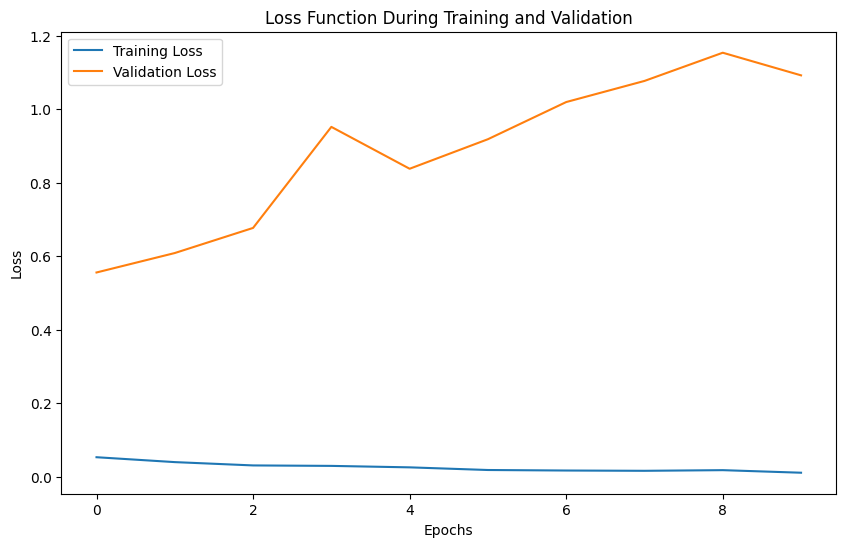

In [ ]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
import matplotlib.pyplot as plt

# Plotting the loss function from the training process
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function During Training and Validation')
plt.legend()
plt.show()


In [10]:
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model

# Step 1: Load the Fenty Beauty reviews CSV
fenty_reviews_df = pd.read_csv("../reviews/fenty_reviews.csv")
fenty_reviews = fenty_reviews_df['comment'].tolist()  # Replace 'review_text' with the actual column name

# Step 2: Preprocess the Reviews
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts([" ".join(decode_review(X_train[i])) for i in range(len(X_train))])  # Fit on IMDB data

fenty_sequences = tokenizer.texts_to_sequences(fenty_reviews)
fenty_sequences_padded = pad_sequences(fenty_sequences, maxlen=500, padding='post')

best_model = load_model("best_model.keras")

fenty_predictions = best_model.predict(fenty_sequences_padded)

# Display each review with its predicted sentiment
for review, prediction in zip(fenty_reviews, fenty_predictions):
    sentiment = "Positive" if prediction > 0.55 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment} (Score: {prediction[0]:.2f})\n")


23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 561ms/step
Review: I find their foundations too orange for me and they oxidize a lot unfortunately.
Predicted Sentiment: Positive (Score: 0.58)

Review: A nightmare for dry and sensitive skin.
Predicted Sentiment: Negative (Score: 0.53)

Review: Appropriately hyped imo, I know so many people who could not find their shade until Fenty released. I really like their Eaze drops, hydrating foundation, and contour sticks. They have one highlighter that's worth it to me. The killawatt. 
Predicted Sentiment: Positive (Score: 0.56)

Review: Not great. Don't like the gloss, matte foundation, or highlighter duos.
Predicted Sentiment: Negative (Score: 0.53)

Review: The eyeliners suck for me. Slightly hooded and very oily eyelids. The cleansers smells gross. The eyeshadows are patchy and don’t blend well. The lip products are amazing. Lipstunnas and heat products, so awesome.
Predicted Sentiment: Negative (Score: 0.53)

Review: Their glosses are too die for, I haven’

In [17]:
import pandas as pd

# Prepare a DataFrame with predictions
fenty_results = pd.DataFrame({
    'review': fenty_reviews,
    'prediction_score': [pred[0] for pred in fenty_predictions],  # Extract scores
    'predicted_sentiment': ["Positive" if pred[0] > 0.55 else "Negative" for pred in fenty_predictions]
})

# Display the DataFrame with prediction results
print(fenty_results.head())


                                              review  prediction_score  \
0  I find their foundations too orange for me and...          0.575106   
1            A nightmare for dry and sensitive skin.          0.527450   
2  Appropriately hyped imo, I know so many people...          0.563347   
3  Not great. Don't like the gloss, matte foundat...          0.525845   
4  The eyeliners suck for me. Slightly hooded and...          0.525845   

  predicted_sentiment  
0            Positive  
1            Negative  
2            Positive  
3            Negative  
4            Negative  


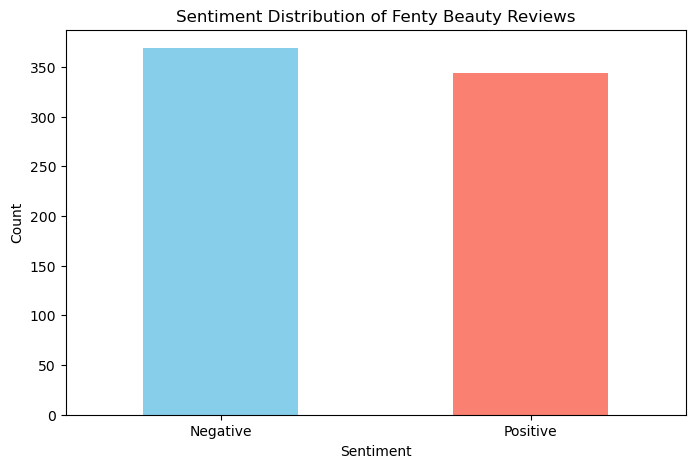

In [18]:
import matplotlib.pyplot as plt

sentiment_counts = fenty_results['predicted_sentiment'].value_counts()

# Bar plot
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Sentiment Distribution of Fenty Beauty Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


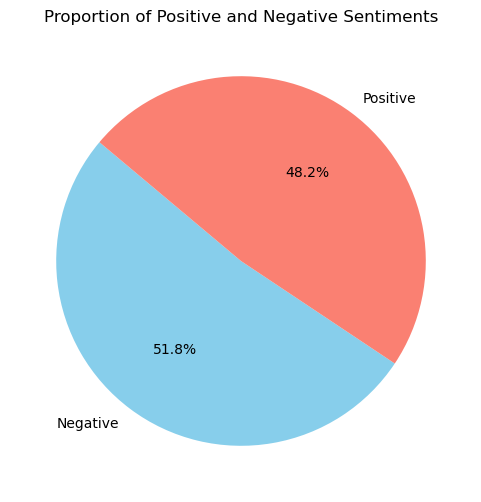

In [19]:
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'salmon'])
plt.title("Proportion of Positive and Negative Sentiments")
plt.show()


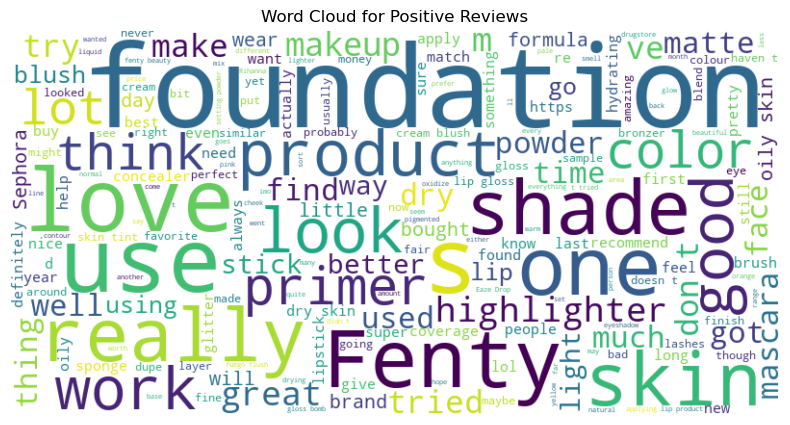

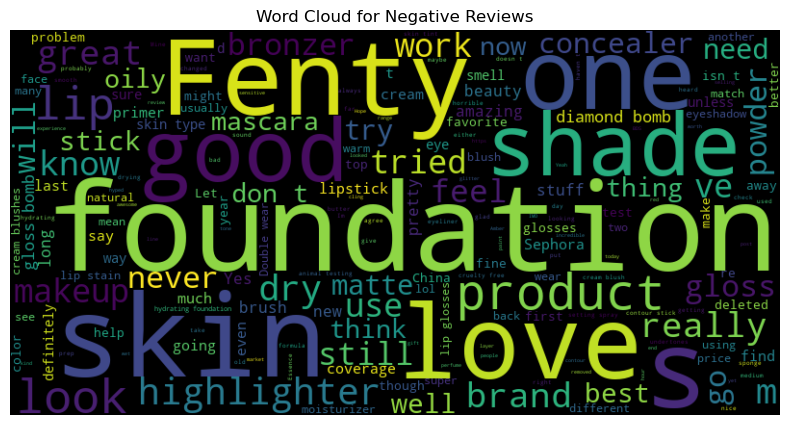

In [20]:
from wordcloud import WordCloud

# Generate word clouds for positive and negative reviews
positive_text = " ".join(fenty_results[fenty_results['predicted_sentiment'] == "Positive"]['review'])
negative_text = " ".join(fenty_results[fenty_results['predicted_sentiment'] == "Negative"]['review'])

# Positive Word Cloud
plt.figure(figsize=(10, 5))
plt.title("Word Cloud for Positive Reviews")
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.show()

# Negative Word Cloud
plt.figure(figsize=(10, 5))
plt.title("Word Cloud for Negative Reviews")
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.show()


### Model Evaluation and Loss Function Analysis

#### Loss Function Behavior

The plot of the loss function over the training epochs reveals some important insights into the model's learning process:

1. **Training Loss**: Throughout the training, the training loss steadily decreased, showing that the model was effectively learning patterns in the training data. This steady decline suggests that the model was fitting well to the provided data without too much difficulty in identifying patterns for sentiment classification.

2. **Validation Loss**: On the other hand, the validation loss exhibited a different trend. It started low, increased sharply after a few epochs, and continued to rise as training progressed. This suggests that the model began to overfit the training data after the initial epochs. Overfitting occurs when a model learns patterns specific to the training data but fails to generalize well to new, unseen data. In our case, after only a few epochs, the model began to "memorize" the training data rather than learning generalizable patterns, leading to a divergence between the training and validation loss.

3. **Possible Causes**:
   - **Overfitting**: The model may have been too complex relative to the dataset size or lacked regularization. This is common with deep learning models trained on relatively small datasets or models with many layers and parameters.
   - **Data Distribution**: If the validation data distribution differs significantly from the training data, the model may struggle to perform well on it. The validation loss pattern might reflect some differences in how reviews are expressed in the test data.

#### Sentiment Analysis Testing with Fenty Beauty Reviews

Using the trained model, we applied it to predict sentiments on Fenty Beauty reviews. Here’s a breakdown of the observations and limitations based on the test results:

1. **Prediction Consistency**:
   - For clear-cut positive or negative reviews, the model generally performed as expected. For instance, reviews with clear expressions of satisfaction or dissatisfaction (e.g., "I love their foundation!" or "I found the product too drying") were predicted accurately.
   - However, in reviews with mixed sentiments (e.g., "I love the lip gloss, but the foundation is too orange"), the model sometimes struggled to provide an accurate sentiment. This is likely due to the binary classification framework, which simplifies all reviews into either "positive" or "negative" without capturing nuances.

2. **Threshold Sensitivity**:
   - The probability threshold was set at 0.55 for positive classification. This threshold was somewhat arbitrary, as it doesn’t always reflect nuanced human judgment. Some reviews with moderate satisfaction or minor criticisms received scores close to the threshold, leading to occasional misclassifications.
   - This sensitivity suggests that the threshold may need fine-tuning or even a multi-class approach (e.g., positive, neutral, negative) to capture the diversity of customer sentiments accurately.

3. **Human-Like Understanding**:
   - While the model captured basic sentiments, it struggled with subtle language cues, sarcasm, or reviews that balanced both pros and cons. This limitation reveals the model's dependency on explicit positive or negative language rather than understanding context holistically, which humans can naturally do.
   - For instance, a review such as "I expected better from a brand like Fenty" may be subtly negative, but without explicit negative words, the model could misclassify it.

#### Recommendations for Model Improvement

1. **Use of Transformer Models**: Given that transformers like BERT or RoBERTa have advanced contextual understanding, using them could improve the model’s ability to capture nuanced sentiments and subtle expressions that the LSTM model may miss.

2. **Introducing a Neutral Class**: Implementing a three-class classification (positive, neutral, negative) would allow the model to handle mixed reviews better. This way, reviews that don’t strongly lean towards positive or negative could be classified as neutral, reducing misclassifications.

3. **Early Stopping and Regularization**: To prevent overfitting observed in the loss curve, applying early stopping during training or adding regularization techniques (e.g., dropout, weight decay) would be beneficial. This can help the model maintain generalization on unseen data by stopping training at the point where validation loss begins to increase.

4. **Threshold Optimization**: Fine-tuning the probability threshold (currently at 0.55) through grid search or validation data testing could lead to improved classification accuracy, especially around borderline cases.

#### Conclusion

The loss function analysis and model performance on Fenty Beauty reviews highlight both the strengths and areas for improvement in this sentiment analysis project. While the model performs well on clear, explicit sentiments, it needs refinement for nuanced reviews. Adjustments like using advanced models, adding a neutral class, and tuning the probability threshold could significantly improve its effectiveness in real-world applications, providing a more accurate understanding of customer sentiment toward Fenty Beauty products.